<a href="https://colab.research.google.com/github/DiegoEscanciano/UCM_MACH/blob/main/C%C3%B3digo/Entrega_DiegoEscanciano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimación del precio de una vivienda 

En este notebook haremos un análisis exploratorio básico de la base de datos de viviendas [House Sales in King COunty, USA](https://www.kaggle.com/harlfoxem/housesalesprediction), para familiarizarnos con los datos y posteriormente aplicar técnicas de machine learning sobre ellos. 

Para cada vivienda, se tienen los siguientes atributos, características o features (o descriptores, o dimensiones...):

| Atributo | descripción |
| :- |:- |
|*id*| identificador de la vivienda|
| *date*| fecha
| *price*| precio
| *bedrooms*| número de habitaciones
| *bathrooms*| número de baños/aseos
| *sqtf_living*| superficie habitable (en pies al cuadrado)
| *sqft_lot*| superficie de la parcela (en pies al cuadrado)
| *floors*| número de plantas
| *waterfront*| indica si la vivienda tiene acceso a un lago
| *view*| tipo de vista (variable numérica)
| *condition*| condición de la vivienda (variable númerica)
| *grade*| medida de la calidad de la construcción (variable numérica)
| *sqft_above*| superficie por encima del suelo (en pies al cuadrado)
| *sqft_basement*| superficie del sótano (en pies al cuadrado)
| *yr_built*| año de construcción de la vivienda
| *yr_renovated*| año de renovación de la vivienda
| *lat*| latitud de la parcela
| *long*| longitud de la parcela
| *sqft_living15*| superficie habitable promedio de los 15 vecinos más cercanos 				
| *sqft_lot15*| superficie de la parcela promedio de los 15 vecinos más cercanos

Vamos a utilizar **DataFrames** de [Pandas](http://pandas.pydata.org/). Como es sabido, Pandas es un módulo de python de código abierto para el análisis de datos, que proporciona estructuras de datos fáciles de utilizar. Como guía de referencia básica, puede consultarse la [cheat sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf)

In [1]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [2]:
house_data = pd.read_csv("https://raw.githubusercontent.com/DiegoEscanciano/UCM_MACH/main/Data/kc_house_data.csv") # cargamos fichero
house_data.head().T                                   # visualizamos 5 primeras filas

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,20141013T000000,20141209T000000,20150225T000000,20141209T000000,20150218T000000
price,221900.0,538000.0,180000.0,604000.0,510000.0
bedrooms,3,3,2,4,3
bathrooms,1.0,2.25,1.0,3.0,2.0
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1.0,2.0,1.0,1.0,1.0
waterfront,0,0,0,0,0
view,0,0,0,0,0


## Tratamiento de la base de datos inicial

In [3]:
house_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Podemos observar que todas las variables son de tipo numérico, así que no tenemos que codificar ninguna de ellas. Por otro lado, los atributos *id* y *date* no nos aportan información, así que los descartamos del DataFrame

In [4]:
# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

Además transforemos las variables de superficie para expresarlas en $m^2$ y posteriormente renombraremos las columnas.

In [5]:
# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

También puede resultar interesante añadir nuevas variables como la de años de la vivienda, definida como el año actual (2023) menos el año de construcción.

In [6]:
# añadimos las nuevas variables
house_data['years']            = 2023 - house_data['yr_built']
house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['lat_plus_long']    = house_data['lat']*house_data['long']

# visualizamos
house_data

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,98178,47.5112,-122.257,124.490074,524.902176,68,9,3.00,4.697071,-5808.576778
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,98125,47.7210,-122.319,157.006138,709.686323,72,9,6.75,5.475462,-5837.184999
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,98028,47.7379,-122.233,252.696269,748.984308,90,4,2.00,4.270192,-5835.146731
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,98136,47.5208,-122.393,126.348134,464.515200,58,16,12.00,5.204501,-5816.213274
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,98074,47.6168,-122.045,167.225472,697.051509,36,9,6.00,5.050350,-5811.392356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,142.141651,105.073338,3.0,0,0,3,8,...,98103,47.6993,-122.346,142.141651,140.190687,14,9,7.50,4.956824,-5835.818558
21609,400000.0,4,2.50,214.606022,540.045372,2.0,0,0,3,8,...,98146,47.5107,-122.362,170.012563,668.901888,9,16,10.00,5.368804,-5813.504273
21610,402101.0,2,0.75,94.761101,125.419104,2.0,0,0,3,7,...,98144,47.5944,-122.299,94.761101,186.456401,14,4,1.50,4.551359,-5820.747526
21611,400000.0,3,2.50,148.644864,221.852460,2.0,0,0,3,8,...,98027,47.5345,-122.069,130.993286,119.566212,19,9,7.50,5.001560,-5802.488881


### Valores duplicados

Interesa eliminar los valores duplicados para evitar la redundancia en nuestros análisis. Para ello:

In [7]:
house_data[house_data.duplicated()==True] # Valores duplicados

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
3951,550000.0,4,1.75,223.896326,784.751979,2.0,0,3,4,8,...,98074,47.6499,-122.088,234.115661,1373.943059,87,16,7.00,5.411183,-5817.480991
4352,259950.0,2,2.00,99.406253,60.294073,2.0,0,0,3,9,...,98106,47.5213,-122.357,99.406253,86.214021,15,4,4.00,4.599215,-5814.563704
14983,585000.0,3,2.50,212.747962,472.783571,2.0,0,0,3,9,...,98006,47.5443,-122.172,212.747962,741.737871,22,9,7.50,5.360108,-5808.582220
20054,555000.0,3,2.50,180.231898,298.311661,2.0,0,0,3,8,...,98027,47.5644,-122.093,174.657715,285.955557,14,9,7.50,5.194244,-5807.280289
20524,529500.0,3,2.25,130.993286,84.077251,3.0,0,0,3,9,...,98116,47.5818,-122.402,140.283590,125.604910,9,9,6.75,4.875146,-5824.107484


Tenemos 5 valores duplicados en nuestro dataframe. El método a seguir en este caso es eliminarlos.

In [8]:
house_data=house_data.drop_duplicates()
house_data # Ahora tenemos 21608 registros en lugar de 21613

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
0,221900.0,3,1.00,109.625587,524.902176,1.0,0,0,3,7,...,98178,47.5112,-122.257,124.490074,524.902176,68,9,3.00,4.697071,-5808.576778
1,538000.0,3,2.25,238.760813,672.803816,2.0,0,0,3,7,...,98125,47.7210,-122.319,157.006138,709.686323,72,9,6.75,5.475462,-5837.184999
2,180000.0,2,1.00,71.535341,929.030400,1.0,0,0,3,6,...,98028,47.7379,-122.233,252.696269,748.984308,90,4,2.00,4.270192,-5835.146731
3,604000.0,4,3.00,182.089958,464.515200,1.0,0,0,5,7,...,98136,47.5208,-122.393,126.348134,464.515200,58,16,12.00,5.204501,-5816.213274
4,510000.0,3,2.00,156.077107,750.656563,1.0,0,0,3,8,...,98074,47.6168,-122.045,167.225472,697.051509,36,9,6.00,5.050350,-5811.392356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,142.141651,105.073338,3.0,0,0,3,8,...,98103,47.6993,-122.346,142.141651,140.190687,14,9,7.50,4.956824,-5835.818558
21609,400000.0,4,2.50,214.606022,540.045372,2.0,0,0,3,8,...,98146,47.5107,-122.362,170.012563,668.901888,9,16,10.00,5.368804,-5813.504273
21610,402101.0,2,0.75,94.761101,125.419104,2.0,0,0,3,7,...,98144,47.5944,-122.299,94.761101,186.456401,14,4,1.50,4.551359,-5820.747526
21611,400000.0,3,2.50,148.644864,221.852460,2.0,0,0,3,8,...,98027,47.5345,-122.069,130.993286,119.566212,19,9,7.50,5.001560,-5802.488881


### Análisis de datos missing

Vamos a llevar a cabo el análisis de datos missing.

In [15]:
#Distribución de los NaN's por columnas
pd_series_null_columns = house_data.isnull().sum().sort_values(ascending=False)
pd_null_columnas = pd.DataFrame(pd_series_null_columns, columns=['nulos_por_columnas'])     
pd_null_columnas['porcentaje_nulos_por_columnas'] = pd_null_columnas['nulos_por_columnas']/house_data.shape[0]
pd_null_columnas

,nulos_por_columnas,porcentaje_nulos_por_columnas
price,0,0.0
bedrooms,0,0.0
log_sqm_living,0,0.0
bed_bath_rooms,0,0.0
bedrooms_squared,0,0.0
years,0,0.0
sqm_lot15,0,0.0
sqm_living15,0,0.0
long,0,0.0
lat,0,0.0


In [19]:
#Distribución de los NaN's por filas
pd_series_null_rows = house_data.isnull().sum(axis=1).sort_values(ascending=False)
pd_series_null_rows.sum()

0

Por tanto no tenemos valores nulos ni por filas ni por columnas en nuestro dataset house_data. Si hubieramos tenido alguno podríamos haberlos sustituido por la media (en caso de variables continuas) o la moda (en caso de variables discretas) entre otras posibilidades.

## Análisis Exploratorio

[Hacer un análisis exploratorio decente]

Realizamos ahora la matriz de correlaciones para ver si existe correlación entre los atributos para intentar evitar la colinealidad entre las variables, ya que en los algoritmos de machine learning esto suele inducir a error.

In [9]:
house_data.corr()

,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,...,zip_code,lat,long,sqm_living15,sqm_lot15,years,bedrooms_squared,bed_bath_rooms,log_sqm_living,lat_plus_long
price,1.000000,0.308326,0.525146,0.702035,0.089652,0.256893,0.266371,0.397409,0.036345,0.667541,...,-0.053179,0.307002,0.021587,0.585378,0.082435,-0.054062,0.210970,0.516627,0.611700,-0.265517
bedrooms,0.308326,1.000000,0.515956,0.576640,0.031671,0.175608,-0.006591,0.079411,0.028370,0.357143,...,-0.152683,-0.008970,0.129395,0.391571,0.029197,-0.154410,0.802087,0.802541,0.620835,0.053537
bathrooms,0.525146,0.515956,1.000000,0.754717,0.087751,0.500754,0.063747,0.187892,-0.124941,0.665029,...,-0.203837,0.024587,0.223065,0.568692,0.087192,-0.506038,0.335776,0.890182,0.761364,0.056643
sqm_living,0.702035,0.576640,0.754717,1.000000,0.172809,0.354181,0.103817,0.284627,-0.058825,0.762893,...,-0.199396,0.052514,0.240150,0.756398,0.183258,-0.318253,0.379532,0.777447,0.954322,0.037843
sqm_lot,0.089652,0.031671,0.087751,0.172809,1.000000,-0.005113,0.021598,0.074744,-0.008988,0.113688,...,-0.129595,-0.085683,0.229530,0.144596,0.718552,-0.053154,0.019292,0.075086,0.148846,0.156968
floors,0.256893,0.175608,0.500754,0.354181,-0.005113,1.000000,0.023731,0.029383,-0.263728,0.458074,...,-0.059153,0.049595,0.125592,0.280080,-0.011180,-0.489244,0.106168,0.384330,0.367794,0.000027
waterfront,0.266371,-0.006591,0.063747,0.103817,0.021598,0.023731,1.000000,0.401992,0.016648,0.082799,...,0.030283,-0.014272,-0.041916,0.086466,0.030698,0.026150,-0.001570,0.042194,0.079307,-0.001995
view,0.397409,0.079411,0.187892,0.284627,0.074744,0.029383,0.401992,1.000000,0.045819,0.251426,...,0.084857,0.006047,-0.078598,0.280391,0.072566,0.053196,0.056246,0.172059,0.246690,-0.033045
condition,0.036345,0.028370,-0.124941,-0.058825,-0.008988,-0.263728,0.016648,0.045819,1.000000,-0.144599,...,0.002998,-0.014975,-0.106590,-0.092920,-0.003449,0.361306,0.026895,-0.070029,-0.048218,-0.024238
grade,0.667541,0.357143,0.665029,0.762893,0.113688,0.458074,0.082799,0.251426,-0.144599,1.000000,...,-0.184875,0.114100,0.198496,0.713396,0.119319,-0.446887,0.218779,0.588113,0.743883,-0.031603


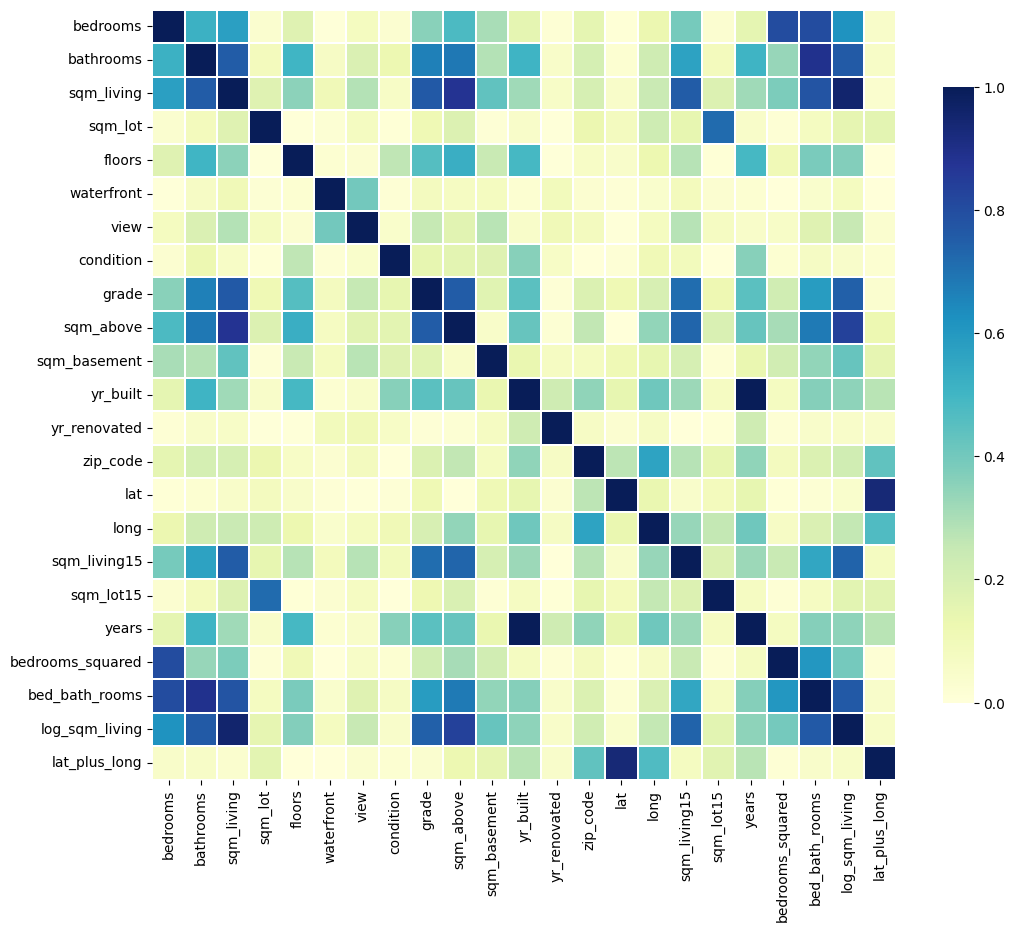

In [20]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(house_data.drop(['price'], axis=1).corr())

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Después de ver esta matriz de correlaciones hay muchas variables que podemos eliminar por redundancia respecto a otras, por ejemplo years con yr_built.

Eliminaremos las variables yr_built, bed_bath_rooms, log_sqm_living, lat, long y resulta:

In [21]:
house_data=house_data.drop(['yr_built','bed_bath_rooms','log_sqm_living','lat','long'], axis=1)

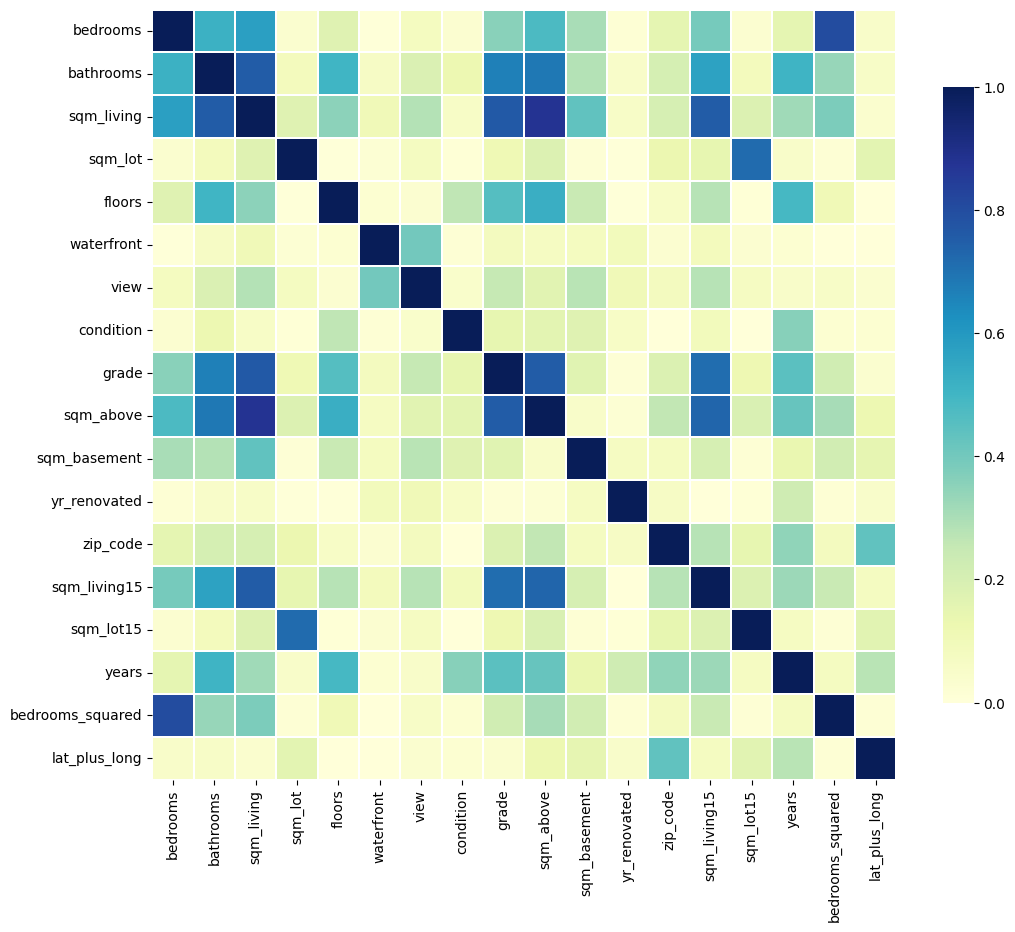

In [22]:
# Compute the correlation matrix
corr = np.abs(house_data.drop(['price'], axis=1).corr())

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

### Análisis de outliers